In [1]:
# Load TikZ extension for drawing
%load_ext jupyter_tikz

# Imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from copy import deepcopy
from qiskit.circuit.library import QuantumVolume, QFT

# MLQCP_FM imports
from disqco.graphs.quantum_network import QuantumNetwork, linear_coupling, grid_coupling, all_to_all, tree_network
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph, SubGraphManager
from disqco.graphs.coarsening.network_coarsener import NetworkCoarsener
from disqco.graphs.coarsening.coarsener import HypergraphCoarsener

from disqco.parti.FM.FM_hetero import run_FM_sparse
from disqco.drawing.tikz_drawing import draw_graph_tikz, draw_subgraph_tikz


In [ ]:
# Problem parameters
num_qubits = 32
num_qpus = 8 # 4-node linear network
qpu_capacity = int(np.ceil(num_qubits / num_qpus)) + 1 
coarsening_factor = 2  # l=2

# Create the quantum circuit (16-qubit Quantum Volume)
from qiskit import transpile
from disqco.circuits.cp_fraction import cp_fraction

# circuit = QFT(num_qubits, do_swaps=False)
# circuit = QuantumVolume(num_qubits, depth=num_qubits)
circuit = cp_fraction(num_qubits, depth=num_qubits, fraction=0.3)
# Transpile to the right gate set
circuit = transpile(circuit, basis_gates=['u', 'cp'])

# Create the quantum network (4-node linear topology)
qpu_sizes = [qpu_capacity] * num_qpus  # [4, 4, 4, 4]
connectivity = linear_coupling(num_qpus)  # [(0,1), (1,2), (2,3)]
# connectivity = grid_coupling(num_qpus)  
# connectivity = all_to_all(num_qpus)  # Fully connected network
# connectivity = tree_network(num_qpus)  # Tree network


initial_network = QuantumNetwork(qpu_sizes, connectivity)

network = deepcopy(initial_network)  # Use a copy to avoid modifying the original

# Create the hypergraph representation
hypergraph = QuantumCircuitHyperGraph(circuit, group_gates=True)


In [3]:
from disqco.parti.FM.net_coarsened_partitioning import run_full_net_coarsened_FM, check_assignment_validity


results = run_full_net_coarsened_FM(
    hypergraph=hypergraph,
    num_qubits=num_qubits,
    network=initial_network,  
    coarsening_factor=2,
    passes_per_level=20,
    use_multiprocessing=True,
    ML_internal_level_limit=100,
    group_gates=False
)
final_assignment = results['final_assignment']
print(f"Final cost: {results['final_cost']}")



# Check final assignment validity
if check_assignment_validity(final_assignment, initial_network.qpu_sizes, hypergraph):
    print("✅ Final assignment is valid!")
else:
    print("Final assignment is NOT valid! Check capacity constraints and partitioning.")
    raise ValueError("Final assignment does not satisfy capacity constraints.")

Final cost: 465
✅ Final assignment is valid!


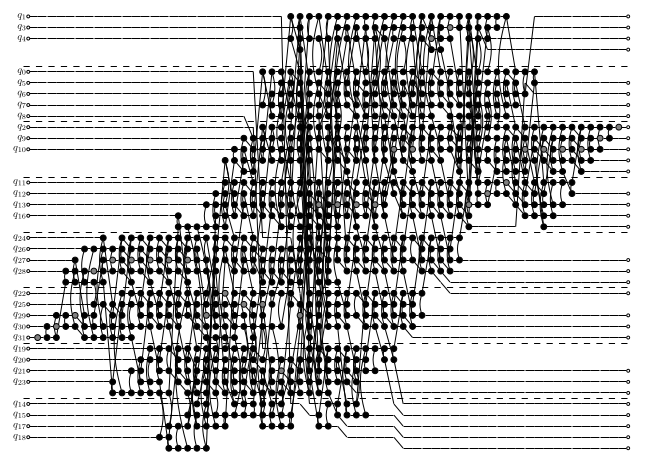

In [4]:
hypergraph.draw(final_assignment, initial_network.qpu_sizes, show_labels=False)